In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/vehicle_monitor.v2i.coco.zip -d /content/data

Archive:  /content/drive/MyDrive/vehicle_monitor.v2i.coco.zip
  inflating: /content/data/README.dataset.txt  
  inflating: /content/data/README.roboflow.txt  
   creating: /content/data/train/
 extracting: /content/data/train/10002_2023-06-24-21-07-04_png.rf.02ba52bd195e06042c0cd8c78be15864.jpg  
 extracting: /content/data/train/10020_2023-06-24-21-10-06_png.rf.79d7b138aa77f30497fbb3b8dc9a4285.jpg  
 extracting: /content/data/train/10026_2023-06-24-21-11-07_png.rf.b4c7a018bce11025a66478855a211096.jpg  
 extracting: /content/data/train/10086_2023-06-24-21-22-04_png.rf.5e15493dbea916e1186a0cd1960956ba.jpg  
 extracting: /content/data/train/1008_2023-06-23-18-38-38_png.rf.239e437d3957066d8f7ab56f00ec20e9.jpg  
 extracting: /content/data/train/10098_2023-06-24-21-24-30_png.rf.f3c378fc918442349ef21cdb8dfb4ace.jpg  
 extracting: /content/data/train/10110_2023-06-24-21-26-47_png.rf.7252a3f40e13012dc9377b8536837cfb.jpg  
 extracting: /content/data/train/10128_2023-06-24-21-30-03_png.rf.62c094d

In [ ]:
!pip install torch torchvision
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import json
from tqdm import tqdm

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        self.images = list(self.annotations.keys())
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        boxes = []
        labels = []
        for ann in self.annotations[img_name]:
            boxes.append(ann['bbox'])
            labels.append(ann['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        if self.transform:
            image = self.transform(image)
        return image, target

In [ ]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    for images, targets in tqdm(data_loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()
    return total_loss / len(data_loader)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 194MB/s]


Epoch 1/10


Validating: 100%|██████████| 157/157 [04:15<00:00,  1.63s/it]


Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.36s).
Accumulating evaluation results...
DONE (t=0.82s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.586
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Validating: 100%|██████████| 157/157 [04:14<00:00,  1.62s/it]


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.49s).
Accumulating evaluation results...
DONE (t=0.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.574
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.612
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Validating: 100%|██████████| 157/157 [04:15<00:00,  1.62s/it]


Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.32s).
Accumulating evaluation results...
DONE (t=0.38s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.580
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Validating: 100%|██████████| 157/157 [04:14<00:00,  1.62s/it]


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.66s).
Accumulating evaluation results...
DONE (t=0.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.575
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.615
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Validating: 100%|██████████| 157/157 [04:14<00:00,  1.62s/it]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.98s).
Accumulating evaluation results...
DONE (t=0.61s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.756
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Validating: 100%|██████████| 157/157 [04:14<00:00,  1.62s/it]


Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.13s).
Accumulating evaluation results...
DONE (t=0.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.626
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Validating: 100%|██████████| 157/157 [04:14<00:00,  1.62s/it]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.00s).
Accumulating evaluation results...
DONE (t=0.31s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.595
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.628
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Validating: 100%|██████████| 157/157 [04:16<00:00,  1.63s/it]


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.29s).
Accumulating evaluation results...
DONE (t=0.34s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.734
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Validating: 100%|██████████| 157/157 [04:14<00:00,  1.62s/it]


Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.85s).
Accumulating evaluation results...
DONE (t=0.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Validating: 100%|██████████| 157/157 [04:15<00:00,  1.63s/it]


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.99s).
Accumulating evaluation results...
DONE (t=0.28s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.582
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.619
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

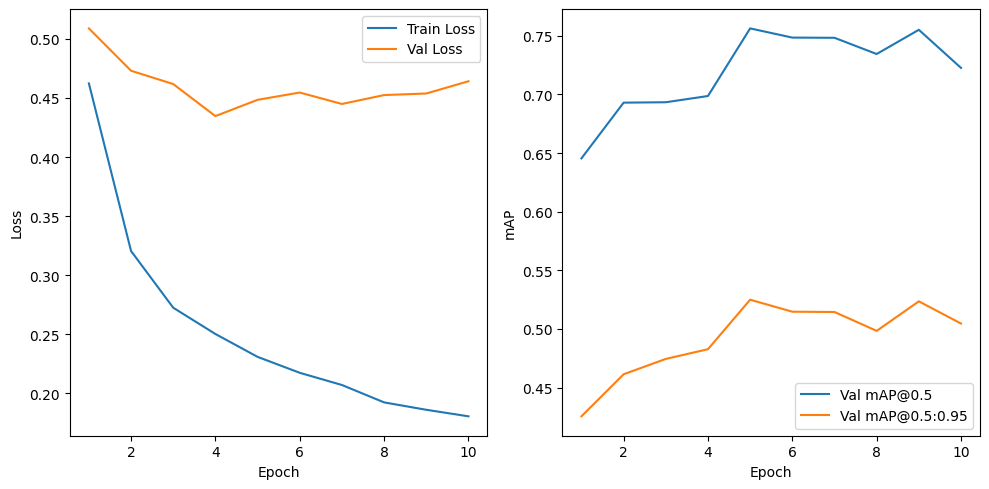

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import os
import torchvision
import numpy as np
from tqdm import tqdm
import csv
import pandas as pd
import matplotlib.pyplot as plt

class CocoDataset(Dataset):
    def __init__(self, root, annFile, transforms=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = [img_id for img_id in self.coco.imgs.keys() if len(self.coco.getAnnIds(imgIds=img_id)) > 0]
        self.transforms = transforms

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img_path = os.path.join(self.root, path)
        img = Image.open(img_path).convert('RGB')
        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            x1, y1, w, h = bbox
            x2 = x1 + w
            y2 = y1 + h
            boxes.append([x1, y1, x2, y2])
            labels.append(ann['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([img_id])
        if self.transforms:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.ids)

# Paths
SAVE_DIR = '/content/drive/MyDrive/model_checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)
TRAIN_DIR = '/content/data/train'
TRAIN_ANN = os.path.join(TRAIN_DIR, '_annotations.coco.json')
VALID_DIR = '/content/data/valid'
VALID_ANN = os.path.join(VALID_DIR, '_annotations.coco.json')

# Transform
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Dataset & DataLoader
train_dataset = CocoDataset(TRAIN_DIR, TRAIN_ANN, transforms=transforms)
valid_dataset = CocoDataset(VALID_DIR, VALID_ANN, transforms=transforms)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=6, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# Model
def get_model(num_classes):
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(train_dataset.coco.getCatIds()) + 1
model = get_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training & Validation functions
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    for images, targets in tqdm(data_loader, desc='Training'):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()
    return total_loss / len(data_loader)

@torch.no_grad()
def validate(model, data_loader, device, coco_gt):
    model.eval()
    total_loss = 0
    coco_results = []
    for images, targets in tqdm(data_loader, desc='Validating'):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Tính loss (train mode để lấy loss dictionary)
        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()
        model.eval()
        # Inference (không truyền targets)
        outputs = model(images)
        for i, output in enumerate(outputs):
            boxes = output['boxes'].detach().cpu().numpy()
            scores = output['scores'].detach().cpu().numpy()
            labels = output['labels'].detach().cpu().numpy()
            image_id = int(targets[i]['image_id'].cpu().numpy()[0])
            for box, score, label in zip(boxes, scores, labels):
                coco_results.append({
                    'image_id': image_id,
                    'category_id': int(label),
                    'bbox': [
                        float(box[0]), float(box[1]),
                        float(box[2] - box[0]), float(box[3] - box[1])
                    ],
                    'score': float(score)
                })
    # mAP calculation
    if len(coco_results) > 0:
        coco_dt = coco_gt.loadRes(coco_results)
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        map50 = coco_eval.stats[1]  # mAP@0.5
        map5095 = coco_eval.stats[0]  # mAP@0.5:0.95
    else:
        map50 = 0.0
        map5095 = 0.0
    return total_loss / len(data_loader), map50, map5095

# CSV log
log_path = os.path.join(SAVE_DIR, 'train_log.csv')
with open(log_path, mode='w', newline='') as log_file:
    log_writer = csv.writer(log_file)
    log_writer.writerow(['epoch', 'train_loss', 'val_loss', 'val_mAP50', 'val_mAP5095'])

num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss, val_map50, val_map5095 = validate(model, valid_loader, device, valid_dataset.coco)
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mAP@0.5: {val_map50:.4f} | Val mAP@0.5:0.95: {val_map5095:.4f}')
    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, os.path.join(SAVE_DIR, f'checkpoint_epoch_{epoch+1}.pth'))
    # Log
    with open(log_path, mode='a', newline='') as log_file:
        log_writer = csv.writer(log_file)
        log_writer.writerow([epoch+1, train_loss, val_loss, val_map50, val_map5095])
print('Training completed!')

# Plot loss and mAP and save to PNG
log_df = pd.read_csv(log_path)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss')
plt.plot(log_df['epoch'], log_df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(log_df['epoch'], log_df['val_mAP50'], label='Val mAP@0.5')
plt.plot(log_df['epoch'], log_df['val_mAP5095'], label='Val mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_plot.png'))
plt.show()